<a href="https://colab.research.google.com/github/elmoose/Emotion-Detection-from-Speech/blob/master/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing the required libraries

In [0]:

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

## Reading the data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Data Directory
# Please edit according to your directory change.
song= "gdrive/My Drive/RAVDESS Dataset/Audio_Speech_Actors_01-24/"
dir_list = os.listdir(song)
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


<b>Filename identifiers</b> 

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).<br/>
Vocal channel (01 = speech, 02 = song).<br/>
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).<br/>
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.<br/>
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").<br/>
Repetition (01 = 1st repetition, 02 = 2nd repetition).<br/>
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).<br/>


In [0]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir(song + i)
    for f in file_list:
        try:
            nm = f.split('.')[0].split('-')
            path = song + i + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            repeat = int(nm[5])

            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = "kids"
            else:
                statement = "dogs"

            data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
            count += 1
        except:
            continue

In [0]:
print (len(data_df))
data_df.head()
data_df.sort_values(['actor','statement','emotion','intensity','repetition'], ascending=True)

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
21,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,1,1
10,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,2,1
20,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,1,2
13,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,2,2
54,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,1,dogs,1,2
36,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,1,dogs,2,2
30,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,1,3
57,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,2,3
39,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,1,dogs,1,3
5,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,1,dogs,2,3


###Plotting the audio file's waveform and its spectrogram

In [0]:
def get_data(data_df, actor):
  actor_1 = data_df.loc[data_df['actor'] == actor]
  actor_1 = actor_1.loc[actor_1['statement'] == 'dogs']
  actor_1 = actor_1.loc[actor_1['repetition'] == 1]
  actor_1 = actor_1.loc[actor_1['intensity'] == 0]
  actor_1.sort_values(['emotion'])
  return actor_1

In [0]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [0]:
for row in actor_1.itertuples(index=True, name='Pandas'):
    filename = getattr(row, "path")
    samples, sample_rate = librosa.load(filename)
    print(sample_rate, len(samples))
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + filename)
    ax1.set_ylabel('Amplitude')
    librosa.display.waveplot(samples, sr=sample_rate)
    
    ax2 = fig.add_subplot(212)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + filename)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')
    
    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std
    spectrogram
    
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)\
    # Let's pad on the first and second deltas while we're at it
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(delta2_mfcc)
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time')
    plt.title('MFCC')
    plt.colorbar()
    plt.tight_layout()


NameError: ignored

In [0]:
filename = data_df.path[10]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

gdrive/My Drive/RAVDESS Dataset/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-02-01.wav


(22050, array([3.0517578e-05, 3.0517578e-05, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32))

In [0]:
len(samples), sample_rate

(69895, 22050)

In [0]:
sample_rate/ len(samples)

0.3154732098147221

Text(0.5, 0, 'Seconds')

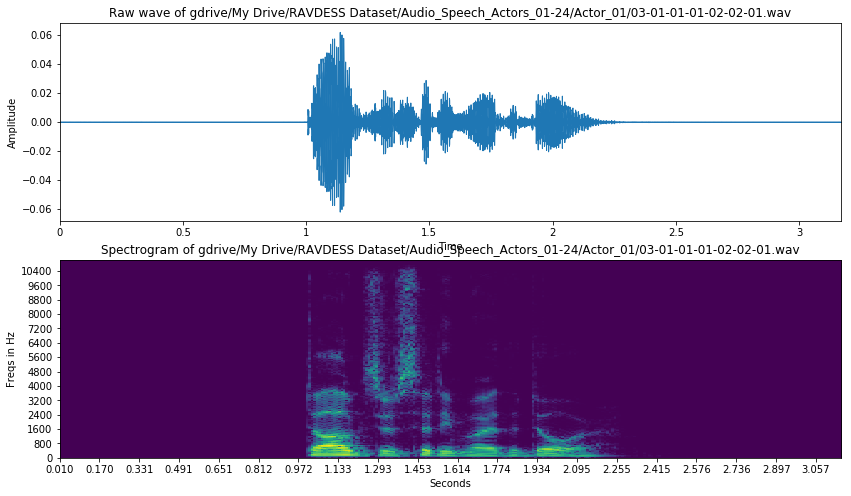

In [0]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [0]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std
spectrogram

array([[-0.45549625, -0.7619848 , -0.7761744 , ...,  0.2864525 ,
         0.29098588, -0.08859976],
       [-0.4586188 , -0.7643435 , -0.77647746, ..., -0.13284755,
         0.05990886,  0.1107497 ],
       [-0.4596853 , -0.76470745, -0.77624696, ..., -0.07057526,
        -0.07702567, -0.1107497 ],
       ...,
       [-0.4612026 , -0.765043  , -0.77644795, ..., -0.12039308,
        -0.11125931, -0.1107497 ],
       [-0.4615929 , -0.76523745, -0.7765242 , ..., -0.12869605,
        -0.11125931, -0.08859976],
       [-0.4616149 , -0.76524544, -0.7765297 , ..., -0.12454457,
        -0.11125931, -0.1107497 ]], dtype=float32)

In [0]:
for i in tqdm(range(len(data_df))):
  filename = data_df.path[i]
  samples, sample_rate = librosa.load(filename)
  aa , bb = librosa.effects.trim(samples, top_db=30)
  librosa.output.write_wav(filename, aa,sample_rate)
  print()

  0%|          | 0/1440 [00:00<?, ?it/s]


EOFError: ignored

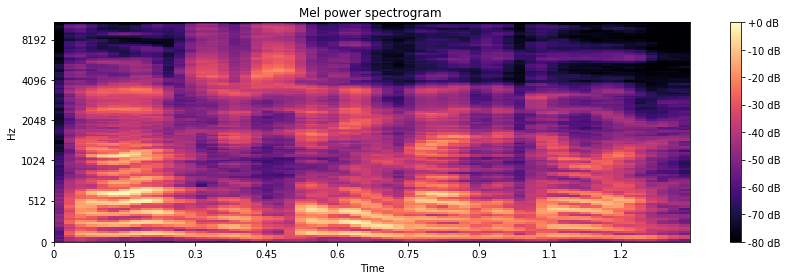

In [0]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

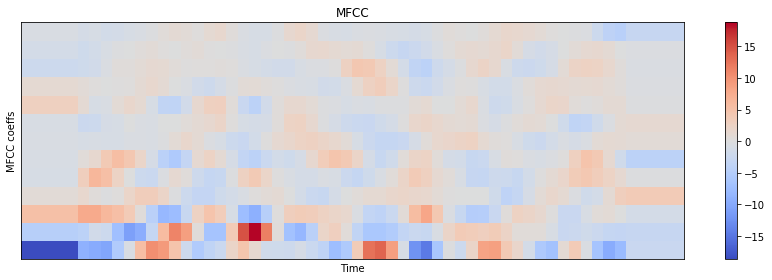

In [0]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## Defining the truth label

In [0]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [0]:
# Select the label set you want by commenting the unwanteds.
data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,1,5,male_angry
1,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,kids,1,8,male_surprised
2,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,2,6,male_fearful
3,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,1,kids,2,6,male_fearful
4,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,1,kids,1,5,male_angry


In [0]:
print (data_df.label.value_counts().keys())

Index(['male_surprised', 'female_sad', 'male_calm', 'male_happy',
       'male_fearful', 'female_disgust', 'male_sad', 'female_angry',
       'male_angry', 'male_disgust', 'female_calm', 'female_surprised',
       'female_happy', 'female_fearful', 'male_neutral', 'female_neutral'],
      dtype='object')


In [0]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

##View Emotion Distribution to split data

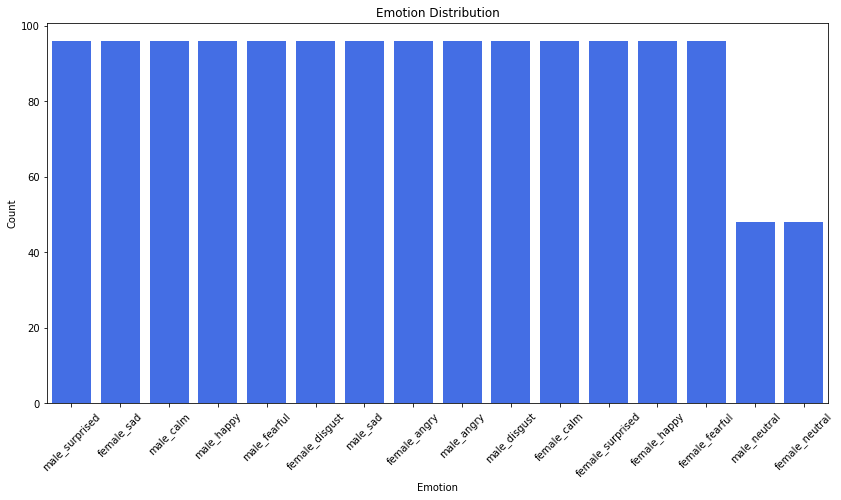

In [0]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

##Data Splitting

In [0]:
# Female Data Set

data1_df = data_df.copy()
data1_df = data1_df[data1_df.label != "male_neutral"]
data1_df = data1_df[data1_df.label != "female_neutral"] #neutral is being excluded because we don't have enough samples
data1_df = data1_df[data1_df.label != "male_happy"]
data1_df = data1_df[data1_df.label != "male_angry"]
data1_df = data1_df[data1_df.label != "male_sad"]
data1_df = data1_df[data1_df.label != "male_fearful"]
data1_df = data1_df[data1_df.label != "male_calm"]
data1_df = data1_df[data1_df.label != "male_disgust"]
data1_df = data1_df[data1_df.label != "male_surprised"].reset_index(drop=True)

tmp1 = data1_df[data1_df.actor == 22]
tmp2 = data1_df[data1_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True) ##final result of data3_df: actor 22 and 24 only, without neutral emotion. This will be the test data set in the end.
data1_df = data1_df[data1_df.actor != 22]
data1_df = data1_df[data1_df.actor != 24].reset_index(drop=True) #final result of data1_df: female actors except 22 and 24, without neutral emotion
print (len(data1_df))
data1_df.head()
#data2_df.label

560


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,2,female,0,dogs,1,2,female_calm
1,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,2,female,0,kids,2,5,female_angry
2,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,2,female,0,dogs,1,3,female_happy
3,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,2,female,1,kids,1,3,female_happy
4,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,2,female,0,kids,1,6,female_fearful


In [0]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_neutral"] #neutral is being excluded because we don't have enough samples
data2_df = data2_df[data2_df.label != "female_neutral"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_disgust"]
data2_df = data2_df[data2_df.label != "female_surprised"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 23]
data4_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True) #final result of data4_df: actor 21 and 23 without neutral emotion. This will be the test data set in the end.
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True) #final result of data2_df: all males except the neutral emotion, and excluding actor 21 and 23
print (len(data2_df))
data2_df.head()

560


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,1,5,male_angry
1,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,kids,1,8,male_surprised
2,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,0,dogs,2,6,male_fearful
3,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,1,kids,2,6,male_fearful
4,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,1,male,1,kids,1,5,male_angry


In [0]:
print (len(data4_df))
data3_df.head()

112


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,22,female,0,kids,1,2,female_calm
1,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,22,female,0,kids,2,2,female_calm
2,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,22,female,0,dogs,1,2,female_calm
3,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,22,female,0,kids,1,3,female_happy
4,gdrive/My Drive/RAVDESS Dataset/Audio_Speech_A...,1,22,female,1,kids,2,2,female_calm


##Getting the features of audio files using librosa

In [0]:

def extract_feature(X,sample_rate):
#     stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)
#     chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=0)
#     mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate), axis=0)
#     contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=0)
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
#                                               sr=sample_rate), axis=0)
    return mfccs #, chroma, mel, contrast, tonnetz

In [0]:
female_data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data1_df))):
    X, sample_rate = librosa.load(data1_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    feature = extract_feature(X,sample_rate)
    female_data.loc[i] = [feature]

100%|██████████| 560/560 [04:36<00:00,  2.14it/s]


In [0]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    feature = extract_feature(X,sample_rate)
    data.loc[i] = [feature]

100%|██████████| 560/560 [10:18<00:00,  1.03s/it]


In [0]:
male_data = data
male_data.head()

,feature
0,"([-70.2677641610773, -70.2677641610773, -70.26..."
1,"([-73.8413701111492, -73.8413701111492, -73.84..."
2,"([-67.55739512198222, -67.55739512198222, -67...."
3,"([-69.67328949566406, -69.69331084873151, -69...."
4,"([-69.05139995492158, -69.05139995492158, -69...."


In [0]:
df_female = pd.DataFrame(female_data['feature'].values.tolist())
female_labels = data1_df.label

df_male = pd.DataFrame(male_data['feature'].values.tolist())
male_labels = data2_df.label

In [0]:
df3.head()

NameError: ignored

In [0]:
df_female = pd.concat([df_female,female_labels], axis=1)
df_male = pd.concat([df_male, male_labels], axis=1)

In [0]:
df_female = df_female.rename(index=str, columns={"0": "label"})
df_male = df_male.rename(index=str, columns={"0": "label"})
print(len(df_female))
print(len(df_male))

560
560


In [0]:
df_female.head(10)

,0,1,2,3,4,label
0,"[-65.19159136331001, -65.19159136331001, -65.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.716875820509102, 12.716875820509102, 12.71...","[0.07998003740812454, 0.06257599597001905, 0.0...",female_calm
1,"[-65.70765240065282, -65.70765240065282, -63.1...","[0.8600066768401137, 0.846110661386863, 0.8774...","[5.74833640656816e-10, 1.1780483245162935e-09,...","[18.764949409387896, 13.026749061716469, 13.43...","[-0.04732868393484727, -0.03935018326303185, -...",female_calm
2,"[-64.6485105289988, -64.6485105289988, -64.648...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.91624363...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.76471302...","[13.120567269418487, 13.120567269418487, 13.12...","[-0.010770638621314131, -0.01697888152959589, ...",female_calm
3,"[-61.44454039609456, -61.44454039609456, -61.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.9525697311674791, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.325133548972245e-1...","[20.429337360591052, 20.429337360591052, 20.42...","[0.04598596321351106, 0.04392870988923214, 0.0...",female_calm
4,"[-65.278048576704, -65.278048576704, -65.27804...","[0.947564800145972, 0.9538648052341677, 0.9549...","[4.597183695409378e-11, 2.7976544460480195e-11...","[14.560822916670963, 4.433034598767547, 3.5216...","[0.027496780533182413, 0.02341667848671931, 0....",female_calm
5,"[-65.19014877058666, -65.19014877058666, -65.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[15.846825754763728, 15.846825754763728, 15.84...","[-0.07222489348966313, -0.046077155482457506, ...",female_calm
6,"[-63.83122385717259, -63.83122385717259, -63.8...","[0.9039596265644949, 0.9293283638783373, 0.791...","[4.5390516260844467e-10, 5.590905341808692e-10...","[19.92997991090389, 14.53416335868215, 13.6619...","[0.010176423949287432, 0.0008009858253707364, ...",female_calm
7,"[-64.09737404413013, -64.09737404413013, -64.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[17.56199429932488, 17.56199429932488, 17.5619...","[-0.008978367075441994, -0.0035861496666513663...",female_calm
8,"[-57.672392425961704, -58.346809634087336, -58...","[0.8628654701737862, 0.7542105034325602, 0.762...","[3.189099073924619e-07, 4.2483720356702175e-07...","[18.774947855970375, 13.227369441617839, 16.77...","[0.01348610710036667, -0.012937936821435706, -...",female_happy
9,"[-61.040763343199394, -61.040763343199394, -61...","[0.0, 0.9528197003305109, 0.9323202434851243, ...","[0.0, 1.1621947994855079e-12, 6.51244694239426...","[15.246482933376413, 4.789237148844087, 12.868...","[0.05277499537315746, 0.043580686885343355, 0....",female_happy


In [0]:
df_male.head()

,0,1,2,3,4,label
0,"[-70.2677641610773, -70.2677641610773, -70.267...","[0.0, 0.8737948549759289, 0.8163388116659025, ...","[0.0, 3.124219287545778e-14, 2.128680488192821...","[10.66167804206249, 6.640794406719947, 9.07429...","[0.010737689693031351, 0.00987592799685889, 0....",male_calm
1,"[-73.8413701111492, -73.8413701111492, -73.841...","[0.9369113367289419, 0.8534055527057287, 0.855...","[5.851456457302554e-12, 6.726626665872513e-11,...","[18.44843454648398, 12.079900701821689, 12.399...","[0.005829519325183295, 0.0035562536120233787, ...",male_calm
2,"[-67.55739512198222, -67.55739512198222, -67.5...","[0.7384014261566417, 0.7313808412045274, 0.735...","[4.308447329292677e-12, 6.202937343236951e-10,...","[16.069131131197686, 9.930237117312256, 10.539...","[0.019704534142163613, 0.011901809283927789, 0...",male_calm
3,"[-69.67328949566406, -69.69331084873151, -69.6...","[0.7724678402916938, 0.7958314894426112, 0.827...","[9.186825445231774e-10, 1.0175489279625506e-09...","[20.91600444124443, 9.93854995443462, 12.80158...","[0.05721985583954659, 0.04428618848683894, 0.0...",male_calm
4,"[-69.05139995492158, -69.05139995492158, -69.0...","[0.9400281737650413, 0.7812784008942907, 0.652...","[2.2387041352112575e-10, 2.2984927601592892e-1...","[19.7414958207068, 12.839740274698958, 11.1704...","[-0.02197157767137732, -0.009672535366236803, ...",male_calm


In [0]:
df_female.isnull().sum().sum()

0

In [0]:
df_male.isnull().sum().sum()

0

In [0]:
df_female = df_female.fillna(0)
df_male = df_male.fillna(0)
df_female.head()

,0,1,2,3,4,label
0,"[-65.19159136331001, -65.19159136331001, -65.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.716875820509102, 12.716875820509102, 12.71...","[0.07998003740812454, 0.06257599597001905, 0.0...",female_calm
1,"[-65.70765240065282, -65.70765240065282, -63.1...","[0.8600066768401137, 0.846110661386863, 0.8774...","[5.74833640656816e-10, 1.1780483245162935e-09,...","[18.764949409387896, 13.026749061716469, 13.43...","[-0.04732868393484727, -0.03935018326303185, -...",female_calm
2,"[-64.6485105289988, -64.6485105289988, -64.648...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.91624363...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.76471302...","[13.120567269418487, 13.120567269418487, 13.12...","[-0.010770638621314131, -0.01697888152959589, ...",female_calm
3,"[-61.44454039609456, -61.44454039609456, -61.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.9525697311674791, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.325133548972245e-1...","[20.429337360591052, 20.429337360591052, 20.42...","[0.04598596321351106, 0.04392870988923214, 0.0...",female_calm
4,"[-65.278048576704, -65.278048576704, -65.27804...","[0.947564800145972, 0.9538648052341677, 0.9549...","[4.597183695409378e-11, 2.7976544460480195e-11...","[14.560822916670963, 4.433034598767547, 3.5216...","[0.027496780533182413, 0.02341667848671931, 0....",female_calm


In [0]:
df_male.head()

,0,1,2,3,4,label
0,"[-70.2677641610773, -70.2677641610773, -70.267...","[0.0, 0.8737948549759289, 0.8163388116659025, ...","[0.0, 3.124219287545778e-14, 2.128680488192821...","[10.66167804206249, 6.640794406719947, 9.07429...","[0.010737689693031351, 0.00987592799685889, 0....",male_calm
1,"[-73.8413701111492, -73.8413701111492, -73.841...","[0.9369113367289419, 0.8534055527057287, 0.855...","[5.851456457302554e-12, 6.726626665872513e-11,...","[18.44843454648398, 12.079900701821689, 12.399...","[0.005829519325183295, 0.0035562536120233787, ...",male_calm
2,"[-67.55739512198222, -67.55739512198222, -67.5...","[0.7384014261566417, 0.7313808412045274, 0.735...","[4.308447329292677e-12, 6.202937343236951e-10,...","[16.069131131197686, 9.930237117312256, 10.539...","[0.019704534142163613, 0.011901809283927789, 0...",male_calm
3,"[-69.67328949566406, -69.69331084873151, -69.6...","[0.7724678402916938, 0.7958314894426112, 0.827...","[9.186825445231774e-10, 1.0175489279625506e-09...","[20.91600444124443, 9.93854995443462, 12.80158...","[0.05721985583954659, 0.04428618848683894, 0.0...",male_calm
4,"[-69.05139995492158, -69.05139995492158, -69.0...","[0.9400281737650413, 0.7812784008942907, 0.652...","[2.2387041352112575e-10, 2.2984927601592892e-1...","[19.7414958207068, 12.839740274698958, 11.1704...","[-0.02197157767137732, -0.009672535366236803, ...",male_calm


# VII. Data Augmentation

In [0]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




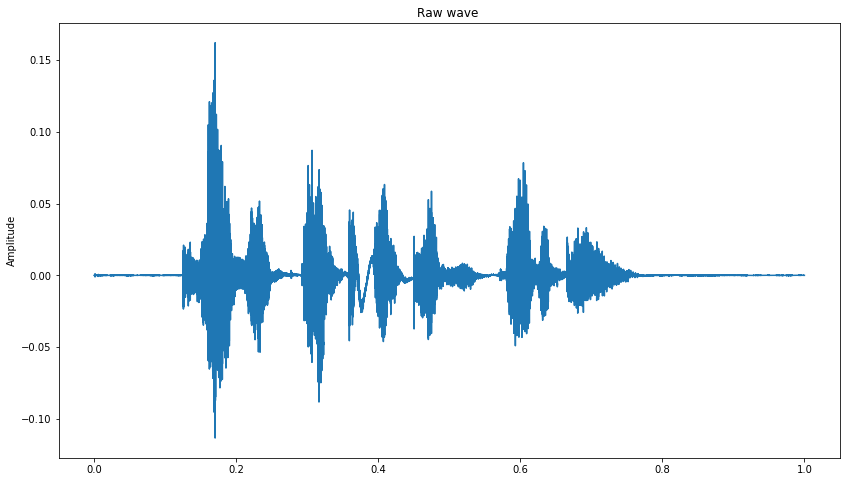

In [0]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

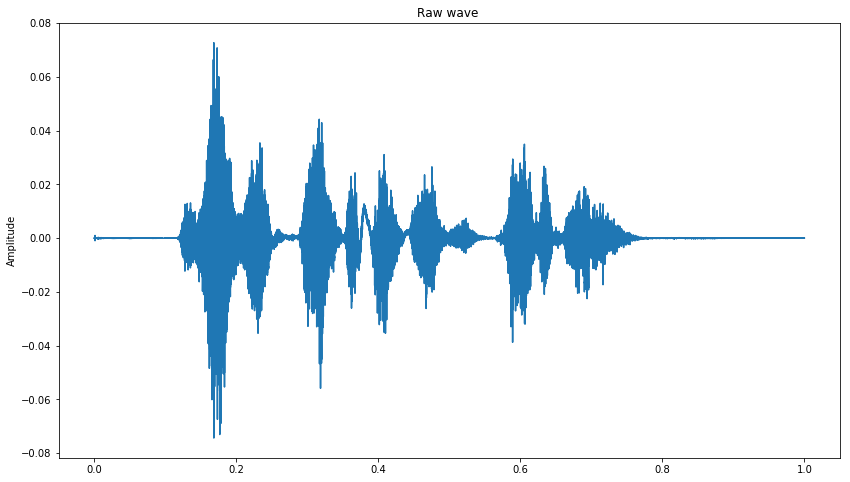

In [0]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [0]:
# Augmentation Method 1: noise

syn_data_female_noise = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data1_df))):
    X, sample_rate = librosa.load(data1_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data1_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data_female_noise.loc[i] = [feature, data1_df.label[i]]
        

NameError: ignored

In [0]:
syn_data_male_noise = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data_male_noise.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 560/560 [02:03<00:00,  4.48it/s]


In [0]:
# Augmentation Method 2: pitch

syn_data_female_pitch = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data1_df))):
    X, sample_rate = librosa.load(data1_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data1_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data_female_pitch.loc[i] = [feature, data1_df.label[i]]

100%|██████████| 560/560 [04:12<00:00,  2.22it/s]


In [0]:
syn_data_male_pitch = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data_male_pitch.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 560/560 [04:09<00:00,  2.26it/s]


In [0]:
len(syn_data_female_noise), len(syn_data_male_noise), len(syn_data_female_pitch), len(syn_data_male_pitch) 

(560, 560, 560, 560)

In [0]:
syn_data_female_noise = syn_data_female_noise.reset_index(drop=True)
syn_data_male_noise = syn_data_male_noise.reset_index(drop=True)
syn_data_female_pitch = syn_data_female_pitch.reset_index(drop=True)
syn_data_male_pitch = syn_data_male_pitch.reset_index(drop=True)

In [0]:
df_female_noise = pd.DataFrame(syn_data_female_noise['feature'].values.tolist())
labels_female_noise = syn_data_female_noise.label
df_female_noise = pd.concat([df_female_noise,labels_female_noise], axis=1)
df_female_noise = df_female_noise.rename(index=str, columns={"0": "label"})
df_female_noise = df_female_noise.fillna(0)
len(df_female_noise)

560

In [0]:
df_male_noise = pd.DataFrame(syn_data_male_noise['feature'].values.tolist())
labels_male_noise = syn_data_male_noise.label
df_male_noise = pd.concat([df_male_noise,labels_male_noise], axis=1)
df_male_noise = df_male_noise.rename(index=str, columns={"0": "label"})
df_male_noise = df_male_noise.fillna(0)
len(df_male_noise)

560

In [0]:
df_female_pitch = pd.DataFrame(syn_data_female_pitch['feature'].values.tolist())
labels_female_pitch = syn_data_female_pitch.label
df_female_pitch = pd.concat([df_female_pitch,labels_female_pitch], axis=1)
df_female_pitch = df_female_pitch.rename(index=str, columns={"0": "label"})
df_female_pitch = df_female_pitch.fillna(0)
len(df_female_pitch)

560

In [0]:
df_male_pitch = pd.DataFrame(syn_data_male_pitch['feature'].values.tolist())
labels_male_pitch = syn_data_male_pitch.label
df_male_pitch = pd.concat([df_male_pitch,labels_male_pitch], axis=1)
df_male_pitch = df_male_pitch.rename(index=str, columns={"0": "label"})
df_male_pitch = df_male_pitch.fillna(0)
len(df_male_pitch)

560

In [0]:
df_female_noise.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-59.021217,-57.422071,-58.486152,-62.614917,-63.526004,-61.652070,-58.686585,-56.769913,-58.400685,-61.550908,-60.764716,-61.978727,-61.723176,-62.024375,-60.219255,-58.838596,-59.608550,-59.352285,-58.711334,-57.515105,-57.702788,-60.157826,-60.186296,-59.555442,-58.586469,-59.379312,-59.398356,-57.862875,-59.102258,-61.058282,-60.276376,-61.269811,-63.888917,-64.090048,-63.273813,-61.456201,-59.545675,-59.860701,-58.495254,-57.772035,...,-55.107811,-54.124599,-54.058518,-56.828222,-58.144402,-56.634772,-52.613955,-51.774678,-54.946413,-57.542929,-59.680456,-57.647936,-58.435719,-57.751963,-58.063609,-57.683750,-55.912755,-55.698615,-55.400294,-55.790417,-57.884561,-59.016307,-59.047863,-56.759765,-57.286389,-58.265390,-60.018584,-61.338724,-59.621954,-57.111796,-54.847569,-54.613197,-55.148730,-55.827100,-58.435100,-57.514943,-54.226144,-52.879727,-52.594387,female_calm
1,-50.034122,-49.324818,-48.951556,-48.423348,-49.664777,-50.989222,-51.541963,-49.760440,-48.709804,-47.572964,-47.913034,-49.677408,-49.451893,-50.286566,-49.376784,-46.969777,-48.364527,-51.489917,-48.850898,-48.453861,-49.704404,-50.861715,-51.498288,-51.378986,-50.189867,-50.258023,-51.963039,-50.008098,-51.970060,-50.721431,-48.297076,-46.770977,-47.361689,-48.408235,-50.222196,-50.881280,-51.064673,-50.489146,-49.657467,-50.704598,...,-48.554454,-47.514599,-47.754205,-50.581679,-51.140262,-50.075672,-49.064540,-48.831800,-47.790410,-48.743323,-52.126061,-51.885010,-49.233479,-47.975965,-49.326184,-51.001324,-47.865228,-47.516609,-48.547322,-51.483437,-51.540953,-50.779361,-50.988046,-49.943401,-51.070196,-54.592139,-50.757452,-51.741512,-49.470746,-47.638695,-46.873471,-50.036816,-51.288999,-49.846471,-47.684251,-49.659328,-50.649899,-51.035257,-49.416283,female_calm
2,-64.601893,-64.519438,-64.572837,-64.463654,-64.656913,-64.766790,-64.709859,-64.406389,-64.492880,-64.391341,-64.247480,-64.177835,-63.995666,-63.583387,-63.661124,-63.959430,-63.455285,-63.864491,-64.428809,-63.849417,-63.909183,-63.264286,-63.681948,-63.839951,-64.212453,-63.783008,-64.707005,-64.665867,-64.531263,-64.682610,-64.022291,-63.758038,-64.031564,-63.869316,-63.788348,-63.938982,-62.747878,-63.266635,-64.366939,-63.577535,...,-48.850830,-50.328710,-49.603855,-51.389648,-53.653732,-56.007109,-53.375727,-53.699659,-55.579272,-58.411111,-57.214398,-58.400193,-60.643853,-60.817332,-57.209007,-58.467621,-63.394806,-63.823218,-62.820912,-60.057770,-59.440136,-59.974147,-61.407902,-60.628056,-58.945120,-60.195366,-62.674581,-62.855376,-61.866441,-62.849036,-62.626950,-62.417835,-61.157580,-60.567873,-60.788671,-61.257976,-63.715494,-63.242727,-63.384868,female_calm
3,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.419465,-61.444674,-60.624292,-59.919161,-59.623368,-59.302105,-58.378379,-59.487280,-58.692637,-57.187056,-58.107511,-59.169233,-59.330852,-60.825658,-61.183375,-61.439572,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,-61.444674,...,-37.559218,-36.534667,-35.043268,-36.115637,-36.254823,-37.554243,-37.854026,-37.887051,-38.986424,-40.942353,-41.450956,-41.414532,-42.117271,-41.132414,-42.148105,-45.256840,-51.224732,-53.473908,-52.285840,-49.750957,-48.430737,-51.036305,-55.336732,-52.696055,-49.623675,-53.124774,-58.022201,-58.087571,-56.357052,-56.989120,-57.130241,-59.156240,-59.052251,-58.778233,-59.838106,-59.542184,-58.885254,-59.131103,-60.424752,female_calm
4,-63.136648,-62.814394,-61.321510,-60.762136,-61.778864,-61.586799,-60.405895,-59.433517,-60.075536,-60.171324,-62.204510,-63.387564,-61.056440,-61.617396,-62.098845,-61.2899

In [0]:
df_male_noise.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.082130,-69.861630,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-70.267604,-66.254317,-63.638682,-68.070590,-70.208249,-69.882447,-69.001482,-66.025406,-63.540659,-68.519389,-70.267604,-69.640644,-68.335573,-69.808635,-67.113295,-66.474734,-68.500234,-66.230114,-63.092615,-62.738971,-65.703970,...,-60.830439,-63.753996,-62.797047,-61.087223,-63.848592,-65.885445,-69.065707,-61.691675,-61.509143,-67.308925,-69.904501,-70.267604,-70.267604,-69.490221,-69.750225,-70.267604,-70.253636,-70.251762,-69.620694,-70.165002,-69.971047,-69.895075,-68.154775,-68.302498,-70.267604,-70.267604,-68.372571,-64.592418,-67.670044,-70.267604,-70.267604,-69.822298,-68.183939,-69.455834,-70.267604,-69.952706,-68.144715,-69.707242,-70.267604,male_calm
1,-72.678335,-73.604693,-73.532010,-73.350763,-73.708806,-73.735486,-73.766867,-72.926559,-72.316334,-73.408088,-73.696418,-72.671255,-65.256610,-63.951297,-64.112237,-61.812477,-61.459536,-59.974481,-62.281833,-70.661932,-67.544367,-69.454317,-70.882588,-71.174511,-73.739260,-71.538971,-69.189415,-65.011401,-62.786993,-60.390955,-62.033958,-64.276473,-64.836561,-67.061329,-66.316112,-64.640864,-62.818847,-58.660995,-53.944680,-53.041636,...,-61.614714,-61.685203,-68.725950,-69.406016,-70.881354,-72.436309,-73.384587,-72.534779,-69.807644,-65.603486,-68.032990,-71.052748,-73.660308,-73.978794,-73.514301,-72.112966,-72.427638,-73.601089,-72.532056,-73.182652,-73.433301,-73.792958,-73.733965,-67.782723,-65.392925,-70.731584,-73.678352,-74.002922,-73.736658,-73.839228,-73.498037,-73.393474,-73.277428,-73.663608,-73.775548,-73.759057,-73.754266,-73.820496,-73.891748,male_calm
2,-58.733189,-57.582457,-58.668761,-60.622803,-59.094404,-61.434633,-58.774354,-59.577683,-61.543960,-60.900157,-59.326617,-61.429825,-60.789836,-58.788747,-60.123644,-58.856590,-57.602809,-58.310320,-60.206945,-60.291476,-60.566619,-61.638714,-62.882368,-61.113366,-57.985959,-57.896415,-58.792826,-58.707213,-58.923628,-59.869124,-58.582167,-61.125702,-61.114958,-59.924509,-61.162108,-59.584084,-59.701897,-59.283350,-57.409968,-52.914816,...,-60.608529,-57.833642,-58.016521,-59.789319,-57.180743,-56.626943,-58.736254,-59.867946,-58.485561,-58.244465,-62.091151,-61.567396,-60.384655,-59.367917,-58.081053,-59.397514,-58.810040,-58.060985,-59.399392,-58.049420,-59.285233,-59.959847,-58.605968,-59.424105,-61.896602,-60.510009,-61.042909,-63.741111,-61.988473,-59.354489,-58.827476,-60.975501,-63.884423,-63.608075,-62.445852,-61.889139,-61.868469,-59.558510,-62.017310,male_calm
3,-61.730353,-61.911145,-62.494941,-61.249494,-62.167722,-62.738584,-62.130701,-59.345099,-60.970634,-62.513494,-61.191264,-61.131395,-60.056403,-60.697879,-60.212220,-60.259835,-60.997951,-60.850705,-60.496007,-62.012838,-60.873278,-60.785252,-62.649930,-59.407222,-56.288037,-57.281310,-62.020451,-60.770541,-59.124239,-58.606621,-59.158016,-58.064698,-59.650053,-58.565498,-58.805606,-57.721911,-57.662464,-56.330843,-54.057169,-53.841417,...,-57.198097,-59.867833,-61.862148,-59.785001,-60.671489,-61.616129,-61.924600,-64.656865,-64.848347,-63.942800,-62.471591,-61.098466,-60.536090,-61.612262,-61.340852,-61.385324,-62.604510,-60.925385,-60.841429,-59.924536,-59.919054,-61.047108,-61.328003,-60.999855,-60.938778,-61.737543,-63.192996,-60.000474,-61.107192,-59.581699,-59.553563,-62.042581,-61.245630,-60.884868,-62.161405,-59.277968,-61.111028,-62.597522,-61.602904,male_calm
4,-58.336758,-57.131098,-58.760040,-57.033376,-56.731596,-54.545611,-54.928632,-57.436412,-58.635587,-56.166468,-56.155803,-57.734151,-57.911583,-58.351788,-55.752837,-56.168406,-56.6

In [0]:
df_female_pitch.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.166179,-67.161018,...,-58.882934,-59.437776,-60.580148,-60.953633,-63.921553,-62.421863,-59.450926,-59.114088,-60.730512,-62.751167,-65.530960,-65.968941,-64.368842,-64.652931,-65.125958,-64.556439,-62.798144,-60.911663,-60.030748,-60.038903,-62.222099,-66.137353,-65.063796,-63.339381,-64.347565,-63.764696,-63.875753,-64.802022,-64.934021,-63.189911,-62.556376,-62.168955,-61.807563,-61.987769,-63.973585,-62.183958,-60.022363,-59.081435,-60.176781,female_calm
1,-66.685176,-66.448250,-65.291501,-63.717172,-62.571472,-63.869807,-62.388463,-58.297175,-56.128245,-55.270442,-55.421416,-57.411894,-60.319958,-59.416505,-58.223353,-58.378921,-59.080524,-59.849459,-60.704335,-59.751457,-58.515012,-59.898993,-62.230794,-64.130477,-64.314325,-64.875415,-66.066891,-66.685176,-66.685176,-65.495583,-61.607166,-58.879851,-58.813539,-60.573855,-63.023084,-63.169477,-63.373876,-64.051536,-66.170573,-65.517114,...,-60.175352,-63.100578,-63.226094,-61.577344,-60.320231,-59.086267,-60.074558,-61.439473,-63.102571,-61.528877,-60.176421,-60.483723,-60.763460,-62.188170,-60.796377,-59.936129,-59.582798,-58.865311,-59.372466,-61.108889,-59.505685,-59.916636,-61.650213,-61.891650,-61.754906,-62.099794,-64.602181,-65.530570,-65.679725,-64.172498,-63.418024,-61.371721,-60.810708,-62.845110,-63.036151,-61.119878,-60.795926,-62.124255,-63.381395,female_calm
2,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.174587,-64.963453,-64.713585,-64.838637,-64.993276,-65.238979,-65.262624,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.380872,-65.357200,-65.007851,-65.380872,-65.380872,...,-51.564068,-52.411922,-52.781343,-53.670648,-56.149949,-56.277443,-57.241582,-56.343213,-57.431017,-60.874150,-61.405429,-62.846683,-63.850786,-62.280187,-63.167674,-63.319949,-64.313055,-64.857342,-64.408773,-64.143642,-64.314793,-64.240741,-64.628815,-63.861810,-63.388160,-63.508458,-64.281884,-65.428004,-65.447161,-65.500473,-64.692514,-64.595492,-64.276399,-63.524803,-63.921250,-64.573997,-65.185950,-65.444126,-65.240296,female_calm
3,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.245380,-67.111672,-66.533930,-65.946478,-65.563677,-64.875247,-63.832723,-63.632278,-63.560181,-62.536061,-61.888864,-62.736833,-62.096748,-61.182051,-61.922801,-62.956597,-64.014778,-65.690108,-66.341865,-66.952986,-67.136160,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,-67.323868,...,-45.548900,-45.771343,-45.202232,-43.468746,-44.232447,-44.787679,-45.724775,-46.071666,-45.026668,-44.946134,-47.349255,-48.414647,-46.932524,-47.182896,-49.006587,-49.819868,-52.947447,-56.360406,-58.182763,-58.418598,-55.404638,-54.772896,-55.947879,-57.066394,-56.971560,-57.662059,-59.809497,-62.807600,-63.520258,-61.224096,-60.814562,-61.661435,-64.047404,-62.956595,-63.465807,-64.892678,-63.404043,-66.076146,-67.268908,female_calm
4,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.193231,-66.1932

In [0]:
df_male_pitch.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.272542,-72.275925,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-68.012620,-65.447870,-69.337539,-72.182426,-71.084018,-70.253389,-68.551297,-67.432002,-69.773519,-72.289734,-72.287764,-72.287764,-71.227045,-70.658052,-69.470523,-70.287764,-69.531513,-66.828205,-65.860214,-66.537383,...,-66.167954,-66.755917,-65.483808,-65.625391,-68.171357,-70.944048,-67.814591,-65.712489,-68.978676,-70.979911,-71.771727,-72.287764,-72.287764,-71.932302,-71.946657,-72.287764,-72.287764,-72.287764,-72.287764,-72.287764,-72.168397,-71.474438,-70.777188,-70.778471,-72.075534,-72.137005,-69.584904,-67.313806,-68.979429,-72.287764,-72.287764,-71.601885,-71.538262,-72.110306,-72.287764,-71.946392,-71.425689,-72.287764,-72.287764,male_calm
1,-77.715695,-77.715695,-77.331486,-77.678124,-77.715695,-77.715695,-77.715695,-77.458605,-76.539595,-77.335552,-77.715695,-74.523053,-69.247975,-66.529593,-65.523741,-64.086758,-63.482112,-63.235623,-64.442946,-69.397278,-71.773235,-72.224069,-74.742711,-76.373060,-76.004175,-74.515338,-72.229551,-68.837473,-65.445717,-63.491151,-64.395523,-66.018440,-67.778958,-69.510265,-70.887876,-66.839932,-64.507485,-62.022576,-59.485175,-56.293509,...,-64.454809,-65.408040,-69.462192,-72.060848,-72.806135,-75.074221,-76.747645,-76.780462,-72.296816,-68.181282,-69.122616,-72.743596,-77.095998,-77.715695,-77.385484,-77.726771,-77.725557,-77.616604,-77.645485,-77.651307,-77.715695,-77.715695,-77.192930,-73.991742,-69.659102,-70.487738,-75.829013,-77.715695,-77.715695,-77.715695,-77.715695,-77.715695,-77.715695,-77.715695,-77.715695,-77.715695,-77.715695,-77.715695,-77.715695,male_calm
2,-70.486982,-70.486982,-70.449723,-70.486982,-70.486982,-69.731630,-69.054160,-70.268848,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-68.917560,-66.645084,-66.078561,-67.651657,-70.173411,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-69.262991,-64.304827,-63.059682,-61.645506,...,-67.149463,-69.497191,-70.308133,-68.932412,-67.599261,-66.385123,-65.500619,-67.354282,-69.363376,-70.487404,-70.298383,-70.486982,-70.486982,-70.169146,-70.185604,-70.486982,-70.486982,-70.319939,-70.386031,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,-70.486982,male_calm
3,-71.244530,-71.683016,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-70.801820,-70.699799,-70.777841,-71.795897,-71.795897,-71.681983,-71.795897,-71.795897,-71.795897,-71.290893,-70.368756,-70.280743,-70.730885,-70.047563,-63.756901,-61.694490,-62.865909,-66.148521,-69.397671,-68.238428,-64.765190,-64.047803,-64.435036,-65.381394,-66.289311,-68.648005,-66.118371,-64.807772,-62.268665,-61.435598,-60.592085,...,-62.014441,-65.452000,-68.734188,-69.167504,-70.673239,-69.244442,-68.439567,-68.925993,-70.601663,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.632338,-70.746748,-70.128319,-71.795897,-70.784652,-71.434752,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.795897,-71.726817,-71.795897,-71.795897,-71.795897,-71.795897,male_calm
4,-71.266058,-71.266058,-71.266058,-71.266058,-71.266058,-71.196954,-71.266058,-71.266058,-71.266058,-71.266058,-71.032514,-71.266058,-70.759780,-69.885386,-70.037648,-70.454307,-69.2

In [0]:
# Combining the Augmented data with original
combined_female = pd.concat([df_female, df_female_noise, df_female_pitch], ignore_index=True)
combined_female = combined_female.fillna(0)
combined_female.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,0,1,2,3,4,label,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,"[-65.19159136331001, -65.19159136331001, -65.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.716875820509102, 12.716875820509102, 12.71...","[0.07998003740812454, 0.06257599597001905, 0.0...",female_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[-65.70765240065282, -65.70765240065282, -63.1...","[0.8600066768401137, 0.846110661386863, 0.8774...","[5.74833640656816e-10, 1.1780483245162935e-09,...","[18.764949409387896, 13.026749061716469, 13.43...","[-0.04732868393484727, -0.03935018326303185, -...",female_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[-64.6485105289988, -64.6485105289988, -64.648...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.91624363...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.76471302...","[13.120567269418487, 13.120567269418487, 13.12...","[-0.010770638621314131, -0.01697888152959589, ...",female_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[-61.44454039609456, -61.44454039609456, -61.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.9525697311674791, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.325133548972245e-1...","[20.429337360591052, 20.429337360591052, 20.42...","[0.04598596321351106, 0.04392870988923214, 0.0...",female_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[-65.278048576704, -65.278048576704, -65.27804...","[0.947564800145972, 0.9538648052341677, 0.9549...","[4.597183695409378e-11, 2.7976544460480195e-11...","[14.560822916670963, 4.433034598767547, 3.5216...","[0.027496780533182413, 0.02341667848671931, 0....",female_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
combined_male = pd.concat([df_male, df_male_noise, df_male_pitch], ignore_index=True)
combined_male = combined_male.fillna(0)
combined_male.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,0,1,2,3,4,label,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,"[-70.2677641610773, -70.2677641610773, -70.267...","[0.0, 0.8737948549759289, 0.8163388116659025, ...","[0.0, 3.124219287545778e-14, 2.128680488192821...","[10.66167804206249, 6.640794406719947, 9.07429...","[0.010737689693031351, 0.00987592799685889, 0....",male_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[-73.8413701111492, -73.8413701111492, -73.841...","[0.9369113367289419, 0.8534055527057287, 0.855...","[5.851456457302554e-12, 6.726626665872513e-11,...","[18.44843454648398, 12.079900701821689, 12.399...","[0.005829519325183295, 0.0035562536120233787, ...",male_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[-67.55739512198222, -67.55739512198222, -67.5...","[0.7384014261566417, 0.7313808412045274, 0.735...","[4.308447329292677e-12, 6.202937343236951e-10,...","[16.069131131197686, 9.930237117312256, 10.539...","[0.019704534142163613, 0.011901809283927789, 0...",male_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[-69.67328949566406, -69.69331084873151, -69.6...","[0.7724678402916938, 0.7958314894426112, 0.827...","[9.186825445231774e-10, 1.0175489279625506e-09...","[20.91600444124443, 9.93854995443462, 12.80158...","[0.05721985583954659, 0.04428618848683894, 0.0...",male_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[-69.05139995492158, -69.05139995492158, -69.0...","[0.9400281737650413, 0.7812784008942907, 0.652...","[2.2387041352112575e-10, 2.2984927601592892e-1...","[19.7414958207068, 12.839740274698958, 11.1704...","[-0.02197157767137732, -0.009672535366236803, ...",male_calm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#  Stratified Shuffle Split

X_female = combined_female.drop(['label'], axis=1)
y_female = combined_female.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X_female, y_female):
    X_train_female, X_test_female = X_female.iloc[train_index], X_female.iloc[test_index]
    y_train_female, y_test_female = y_female.iloc[train_index], y_female.iloc[test_index]

In [0]:
X_male = combined_male.drop(['label'], axis=1)
y_male = combined_male.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X_male, y_male)
    X_train_male, X_test_male = X_male.iloc[train_index], X_male.iloc[test_index]
    y_train_male, y_test_male = y_male.iloc[train_index], y_male.iloc[test_index]

SyntaxError: ignored

In [0]:
y_train_female.value_counts()

female_sad          192
female_calm         192
female_surprised    192
female_angry        192
female_happy        192
female_fearful      192
female_disgust      192
Name: label, dtype: int64

In [0]:
y_train_male.value_counts()

NameError: ignored

In [0]:
y_test_female.value_counts()

female_sad          48
female_fearful      48
female_surprised    48
female_angry        48
female_calm         48
female_happy        48
female_disgust      48
Name: label, dtype: int64

In [0]:
y_test_male.value_counts()

NameError: ignored

In [0]:
X_train_female.isna().sum().sum()

0

In [0]:
X_train_male.isna().sum().sum()

NameError: ignored

In [0]:
X_train_female = np.array(X_train_female)
y_train_female = np.array(y_train_female)
X_test_female = np.array(X_test_female)
y_test_female = np.array(y_test_female)
lb = LabelEncoder()
y_train_female = np_utils.to_categorical(lb.fit_transform(y_train_female))
y_test_female = np_utils.to_categorical(lb.fit_transform(y_test_female))

NameError: ignored

In [0]:
X_train_male = np.array(X_train_male)
y_train_male = np.array(y_train_male)
X_test_male = np.array(X_test_male)
y_test_male = np.array(y_test_male)
lb = LabelEncoder()
y_train_male = np_utils.to_categorical(lb.fit_transform(y_train_male))
y_test_male = np_utils.to_categorical(lb.fit_transform(y_test_male))

NameError: ignored

In [0]:
y_train_female

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
y_train_male

NameError: ignored

In [0]:
X_train_female.shape

(1344, 259)

In [0]:
X_train_male.shape

NameError: ignored

# VIII. Changing dimension for CNN model

In [0]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

NameError: ignored

In [0]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [0]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(16))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


NameError: ignored

In [0]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [0]:
# Plotting Model Summary

model.summary()

ValueError: ignored

In [0]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [0]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

NameError: ignored

In [0]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

## Saving the model

In [0]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [0]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

OSError: ignored

# X. Predicting emotions on the test data

In [0]:
len(data3_df)

112

In [0]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 112/112 [01:03<00:00,  1.79it/s]


In [0]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

InvalidArgumentError: ignored

In [0]:
preds

In [0]:
preds1=preds.argmax(axis=1)

In [0]:
preds1

In [0]:
abc = preds1.astype(int).flatten()

In [0]:
predictions = (lb.inverse_transform((abc)))

In [0]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [0]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [0]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [0]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [0]:
finaldf[20:40]

In [0]:
finaldf.groupby('actualvalues').count()

In [0]:
finaldf.groupby('predictedvalues').count()

In [0]:
finaldf.to_csv('Predictions.csv', index=False)

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [0]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

In [0]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

In [0]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

In [0]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
# class_names = ['male_negative', 'male_positive']
class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'female_neutral', 'female_disgusted', 'female_surprised', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad', 'male_neutral', 'male_disgusted', 'male_surprised']


print_confusion_matrix(c, class_names)